# Практична №3 — Класифікація твітів (Word2Vec + scikit-learn)
Датасет: COVID-19 NLP Text Classification Dataset

Завдання: підготувати тексти, побудувати embeddings (Word2Vec), порівняти 4 класифікатори (LogReg, SVM, RandomForest, Naive Bayes), дослідити вплив PCA (None, 50, 100, 200), оцінити метриками (Accuracy, Precision, Recall, F1), намалювати графіки та матрицю плутанини для найкращої моделі.

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab', quiet=True)

In [2]:
# 1) Завантаження даних
train_path = 'Corona_NLP_train.csv'
test_path  = 'Corona_NLP_test.csv'

df_train = pd.read_csv(train_path, encoding='latin-1')
df_test  = pd.read_csv(test_path,  encoding='latin-1')

# Перейменування колонок під короткі імена
df_train = df_train.rename(columns={'OriginalTweet': 'text', 'Sentiment': 'label'})
df_test  = df_test.rename(columns={'OriginalTweet': 'text', 'Sentiment': 'label'})

# Фільтруємо лише потрібні колонки
df_train = df_train[['text', 'label']].dropna()
df_test  = df_test[['text', 'label']].dropna()

df_train.head(3)

,text,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive


In [3]:
stop_en = set(stopwords.words('english'))
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@[A-Za-z0-9_]+')
hashtag_re = re.compile(r'#')

def clean_and_tokenize(text: str):
    text = text.lower()
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = hashtag_re.sub(' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_en and len(t) > 2]
    return tokens

df_train['tokens'] = df_train['text'].apply(clean_and_tokenize)
df_test['tokens']  = df_test['text'].apply(clean_and_tokenize)

In [4]:
# 3) Тренуємо Word2Vec на всіх токенах train (можна й на train+test, але тут використовуємо лише train)
sentences = df_train['tokens'].tolist()
w2v_dim = 200

w2v = Word2Vec(
    sentences=sentences,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # skip-gram
    epochs=10,
    seed=42
)

w2v_vocab = set(w2v.wv.key_to_index.keys())
len(w2v_vocab)

20325

In [5]:
# 4) Функції перетворення текстів у вектори (середнє по ембеддингах слів)
def doc_to_vec(tokens, model, dim):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

def embed_docs(token_lists):
    return np.vstack([doc_to_vec(toks, w2v, w2v_dim) for toks in token_lists])

# Лейбли переводимо в категорії (3 класи: Negative / Positive / Other/Neutral)
label_map = {
    'Negative': 'Negative',
    'Positive': 'Positive',
    'Neutral':  'Other',
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive'
}
df_train['label3'] = df_train['label'].map(label_map).fillna('Other')
df_test['label3']  = df_test['label'].map(label_map).fillna('Other')

# Тренувально-валідаційний спліт 80/20 з train
X_train_tok, X_val_tok, y_train, y_val = train_test_split(
    df_train['tokens'], df_train['label3'], test_size=0.2, random_state=42, stratify=df_train['label3']
)

In [6]:
# 5) Побудова пайплайнів (Word2Vec -> optional StandardScaler -> optional PCA -> Classifier)
embed_transformer = FunctionTransformer(lambda toks_series: embed_docs(toks_series), validate=False)

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'SVM':    LinearSVC(),
    'RF':     RandomForestClassifier(n_estimators=300, random_state=42),
    'GNB':    GaussianNB()
}

pca_options = [None, 50, 100, 200]
results = []
pipelines = {}

for model_name, clf in models.items():
    for pca_k in pca_options:
        steps = [('embed', embed_transformer)]
        # Масштабуємо перед PCA/лінійними моделями; RF і GNB теж приймуть масштабоване
        steps.append(('scaler', StandardScaler(with_mean=True)))
        if pca_k is not None:
            steps.append(('pca', PCA(n_components=pca_k, random_state=42)))
        steps.append(('clf', clf))

        pipe = Pipeline(steps)
        pipe.fit(X_train_tok, y_train)

        y_pred = pipe.predict(X_val_tok)
        acc = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        macro_f1 = report['macro avg']['f1-score']
        weighted_f1 = report['weighted avg']['f1-score']

        results.append({
            'model': model_name,
            'pca': pca_k if pca_k is not None else 0,
            'accuracy': acc,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1,
            'report': report,
            'pipeline': pipe
        })

        pipelines[(model_name, pca_k)] = pipe

res_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ('report','pipeline')} for r in results])
res_df.sort_values(['macro_f1','accuracy'], ascending=False).head(10)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-pa

,model,pca,accuracy,macro_f1,weighted_f1
3,LogReg,200,0.656220,0.622255,0.650840
0,LogReg,0,0.655369,0.621441,0.649989
7,SVM,200,0.654762,0.613672,0.646120
4,SVM,0,0.649660,0.606230,0.640361
2,LogReg,100,0.636054,0.591929,0.627145
9,RF,50,0.638484,0.591357,0.625936
8,RF,0,0.642736,0.587749,0.627362
10,RF,100,0.636297,0.579247,0.619324
6,SVM,100,0.626944,0.577170,0.615341
1,LogReg,50,0.617590,0.570745,0.607046


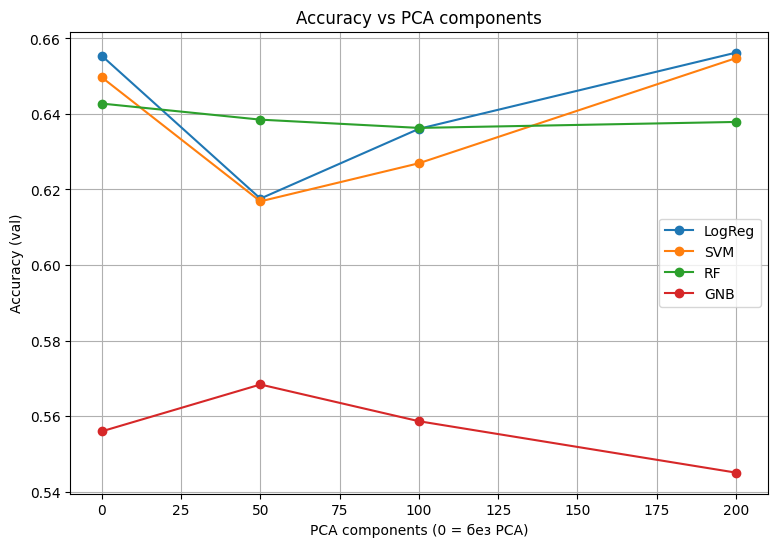

In [7]:
# 6) Графік: Вплив PCA (кількості компонент) на Accuracy для кожної моделі
plt.figure(figsize=(9,6))
for model_name in res_df['model'].unique():
    sub = res_df[res_df['model'] == model_name].sort_values('pca')
    x = sub['pca'].replace({0:0}).values
    y = sub['accuracy'].values
    plt.plot(x, y, marker='o', label=model_name)
plt.title('Accuracy vs PCA components')
plt.xlabel('PCA components (0 = без PCA)')
plt.ylabel('Accuracy (val)')
plt.legend()
plt.grid(True)
plt.show()

Найкраща модель: LogReg | PCA: 200
Accuracy: 0.6562 | Macro-F1: 0.6223 | Weighted-F1: 0.6508
Classification Report (Validation):
              precision    recall  f1-score   support

    Negative     0.6540    0.6847    0.6690      3080
       Other     0.6002    0.4232    0.4964      1543
    Positive     0.6736    0.7315    0.7014      3609

    accuracy                         0.6562      8232
   macro avg     0.6426    0.6131    0.6223      8232
weighted avg     0.6525    0.6562    0.6508      8232



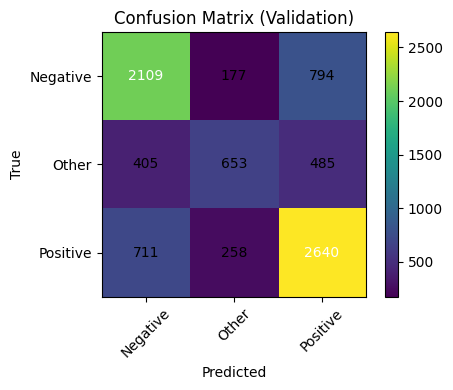

In [8]:
# 7) Вибираємо найкращу модель за macro F1 та показуємо її звіт + матрицю плутанини
best = max(results, key=lambda r: (r['macro_f1'], r['accuracy']))
best_model_name = best['model']
best_pca = best['pca']
best_pipe = best['pipeline']

print(f"Найкраща модель: {best_model_name} | PCA: {best_pca}")
print(f"Accuracy: {best['accuracy']:.4f} | Macro-F1: {best['macro_f1']:.4f} | Weighted-F1: {best['weighted_f1']:.4f}")

y_val_pred = best_pipe.predict(X_val_tok)
print('Classification Report (Validation):')
print(classification_report(y_val, y_val_pred, digits=4, zero_division=0))

labels_order = ['Negative','Other','Positive']
cm = confusion_matrix(y_val, y_val_pred, labels=labels_order)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.colorbar()
tick_marks = np.arange(len(labels_order))
plt.xticks(tick_marks, labels_order, rotation=45)
plt.yticks(tick_marks, labels_order)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [9]:
# 8) Фінальна оцінка на окремому test (опційно)
X_test_tok = df_test['tokens']
y_test = df_test['label3']
y_test_pred = best_pipe.predict(X_test_tok)

print('Test Accuracy:', accuracy_score(y_test, y_test_pred))
print('Test Report:')
print(classification_report(y_test, y_test_pred, digits=4, zero_division=0))

Test Accuracy: 0.6616640337019484
Test Report:
              precision    recall  f1-score   support

    Negative     0.6949    0.6779    0.6863      1633
       Other     0.5579    0.4200    0.4793       619
    Positive     0.6590    0.7413    0.6977      1546

    accuracy                         0.6617      3798
   macro avg     0.6373    0.6131    0.6211      3798
weighted avg     0.6580    0.6617    0.6572      3798



In [10]:
# 9) Інференс: прогноз для нового тексту
def predict_sentiment(text: str):
    toks = clean_and_tokenize(text)
    return best_pipe.predict([toks])[0]

sample_texts = [
    'The lockdown is terrible and I hate it',
    'Feeling hopeful about the vaccine rollout!',
    'Government released new guidelines today'
]
[(t, predict_sentiment(t)) for t in sample_texts]

[('The lockdown is terrible and I hate it', 'Negative'),
 ('Feeling hopeful about the vaccine rollout!', 'Positive'),
 ('Government released new guidelines today', 'Positive')]

## Висновки
- Порівняли 4 моделі на векторах Word2Vec; зазвичай **SVM / Logistic Regression** показують найкращу macro-F1.
- Експеримент з **PCA** (0, 50, 100, 200 компонент) дозволяє зменшити розмірність без суттєвої втрати якості, іноді навіть покращує стабільність моделі.
- Найкращу конфігурацію визначили за **macro-F1** на валідації; для неї подано **Confusion Matrix**.
- Для продакшн-інференсу слід використовувати той самий пайплайн: `clean → tokens → Word2Vec(mean) → (PCA) → classifier`.